# Setup

In [1]:
pip install -r ../../requirements.txt

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-02 08:50:55.767225: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 08:50:56.519468: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-02 08:50:56.519525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14639 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


In [6]:
config = json.load(open("./configs/ext_mnn_em.json"))

# Loading data

In [7]:
from data_loader.abo import ABO

In [8]:
data = ABO(path=config["data"]["path"],
           download=True,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'description2', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,description2,path,product_type,label
0,mobile coverb072mq5brxamazon brand - solimo de...,mobile coverb07w3lj3z9amazon brand - solimo de...,9c/9c5b0d19.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb081hnqhxcamazon brand - solimo de...,mobile coverb01b7rv2siamazon brand - solimo de...,6b/6ba28b04.jpg,CELLULAR_PHONE_CASE,0
2,back coverb0854fqg18amazon brand - solimo desi...,back coverb0854fqg18amazon brand - solimo desi...,89/89dfc617.jpg,CELLULAR_PHONE_CASE,1
3,mobile coverb07tg4p76bamazon brand - solimo de...,mobile coverb07tg4p76bamazon brand - solimo de...,19/19b3ccd2.jpg,CELLULAR_PHONE_CASE,1
4,mobile coverb082dg1lsbamazon brand - symbol me...,mobile coverb0853wmxrcamazon brand - solimo sp...,ab/abcd48ab.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...,...
168189,samsung galaxy m21 mobile caseb07t1jtg5sfind. ...,mobile coverb07vx59rx1amazon brand - solimo de...,19/191d6d6b.jpg,CELLULAR_PHONE_CASE,0
168190,mobile coverb07th2zwnfamazon brand - solimo de...,mobile coverb07th2zwnfamazon brand - solimo de...,b5/b564d277.jpg,CELLULAR_PHONE_CASE,1
168191,mobile coverb0853x5rhnamazon brand - solimo de...,"bed skirts, twin, full, kingb07hkf59m9amazon b...",d0/d02ce449.jpg,CELLULAR_PHONE_CASE,0
168192,back coverb0857lc1n9amazon brand - solimo desi...,back coverb0857lc1n9amazon brand - solimo desi...,78/7827a86d.jpg,CELLULAR_PHONE_CASE,1


In [9]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
text2 = data["description2"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [10]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(168194, 1014)

In [11]:
text2 = tk.tokenize(text2)
text2.shape

(168194, 1014)

## Create embedding weights

In [12]:
weights = tk.create_embedding_weights()
weights.shape

(66, 65)

# Image processing

## Load image model

In [13]:
from utils.img_processing import load_img_model, create_embeddings_from

In [14]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [15]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=1024)

Found 168194 validated image filenames.


2023-06-02 08:51:36.261758: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


In [16]:
img.shape

(168194, 576)

# Save embeddings

In [17]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/{img_model.name}")

In [18]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
np.save(f"{save_path}/text2.npy", text2)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [19]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,description2,path,product_type,label
0,mobile coverb072mq5brxamazon brand - solimo de...,mobile coverb07w3lj3z9amazon brand - solimo de...,9c/9c5b0d19.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb081hnqhxcamazon brand - solimo de...,mobile coverb01b7rv2siamazon brand - solimo de...,6b/6ba28b04.jpg,CELLULAR_PHONE_CASE,0
2,back coverb0854fqg18amazon brand - solimo desi...,back coverb0854fqg18amazon brand - solimo desi...,89/89dfc617.jpg,CELLULAR_PHONE_CASE,1
3,mobile coverb07tg4p76bamazon brand - solimo de...,mobile coverb07tg4p76bamazon brand - solimo de...,19/19b3ccd2.jpg,CELLULAR_PHONE_CASE,1
4,mobile coverb082dg1lsbamazon brand - symbol me...,mobile coverb0853wmxrcamazon brand - solimo sp...,ab/abcd48ab.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...,...
168189,samsung galaxy m21 mobile caseb07t1jtg5sfind. ...,mobile coverb07vx59rx1amazon brand - solimo de...,19/191d6d6b.jpg,CELLULAR_PHONE_CASE,0
168190,mobile coverb07th2zwnfamazon brand - solimo de...,mobile coverb07th2zwnfamazon brand - solimo de...,b5/b564d277.jpg,CELLULAR_PHONE_CASE,1
168191,mobile coverb0853x5rhnamazon brand - solimo de...,"bed skirts, twin, full, kingb07hkf59m9amazon b...",d0/d02ce449.jpg,CELLULAR_PHONE_CASE,0
168192,back coverb0857lc1n9amazon brand - solimo desi...,back coverb0857lc1n9amazon brand - solimo desi...,78/7827a86d.jpg,CELLULAR_PHONE_CASE,1


In [20]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168194, 576)

In [21]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168194, 1014)

In [22]:
text2 = np.load(f"{save_path}/text2.npy", allow_pickle=True)
text2.shape

(168194, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [23]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [24]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [27]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

text2_train = text2[train.index]
text2_test = text2[test.index]

# Save Char CNN config

In [28]:
from models.char_cnn_zhang import CharCNNZhang

In [29]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [30]:
char_cnn = CharCNNZhang(**char_cnn_config)
char_cnn.model

# Build Extended MNN-EM Model

![](../../assets/images/Extended_MNN_EM.png)

In [31]:
from models.mnn_em import ExtendedMNNEM
from utils.metrics import create_metrics

In [32]:
head_1_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_1_fc_layers"],
    "extended": True,
}

In [33]:
head_2_config = {
    "img_input_size": config["model"]["img_1_fc_layers"][-1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["combined_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_2_fc_layers"],
    "extended": False,
}

In [34]:
ext_mnn_em = ExtendedMNNEM(
    head_1_config=head_1_config,
    head_2_config=head_2_config,
    char_cnn=char_cnn.model,
    combined_fc_layers=config["model"]["combined_2_fc_layers"],
    learning_rate=config["model"]["training"]["learning_rate"],
    metrics=create_metrics(config["model"]["training"]["metrics"]))

In [35]:
ext_mnn_em.model.summary(expand_nested=True)

Model: "Extended_MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 1024)         16127426    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Image_Input_Head_Outer (InputL  [(None, 576)]     0           []                  

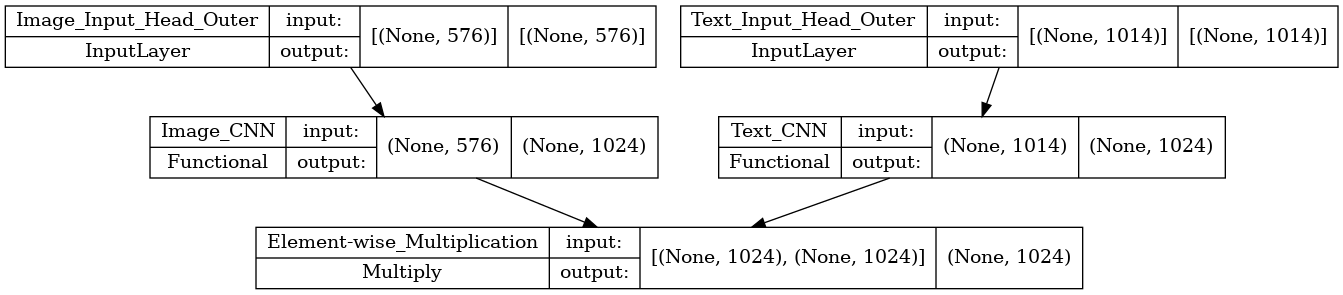

In [36]:
# "Head"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

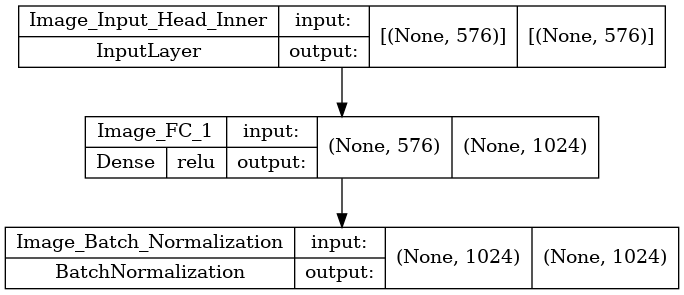

In [37]:
# Image CNN

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

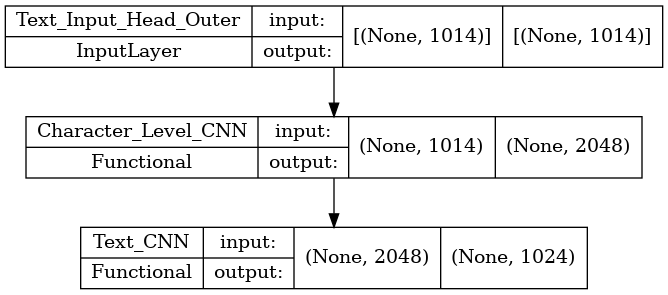

In [38]:
# Text CNN (outer)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

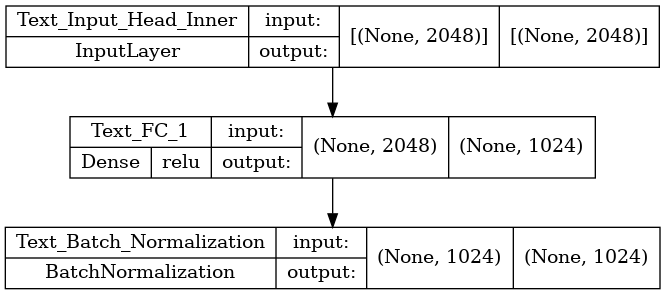

In [39]:
# Text CNN (inner)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3].layers[-1],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

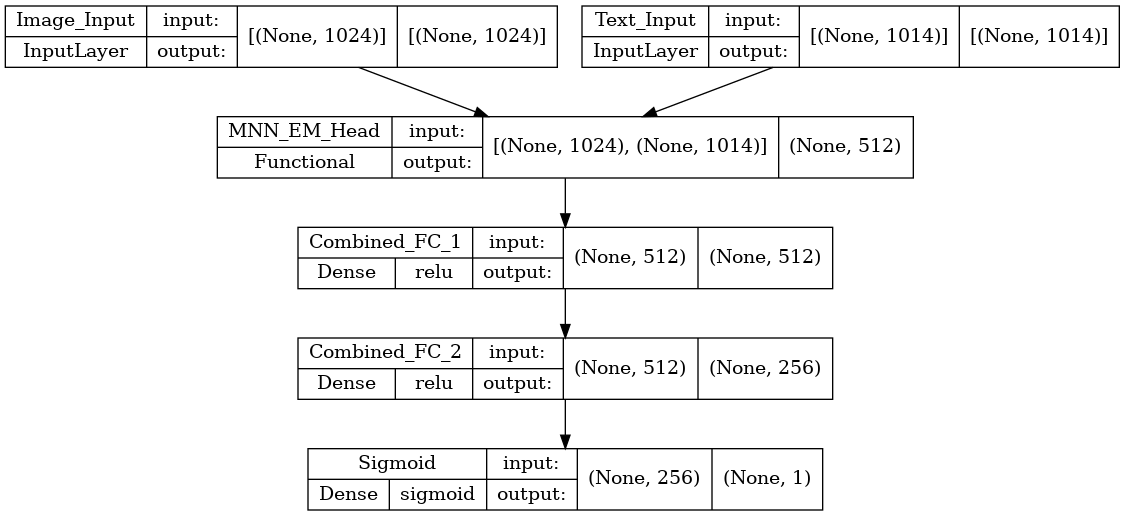

In [40]:
# "Tail"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[4],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

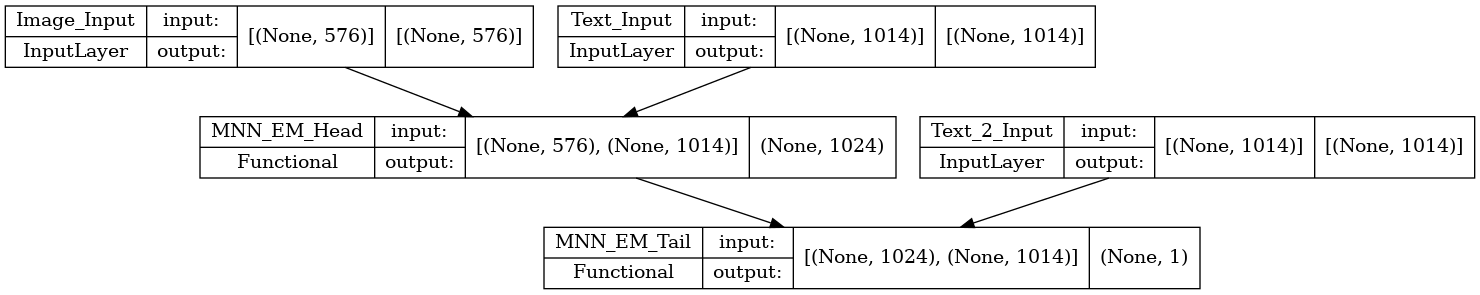

In [41]:
# Full model

tf.keras.utils.plot_model(ext_mnn_em.model,
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [42]:
from utils.metrics import create_callbacks

In [43]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [44]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [45]:
history = ext_mnn_em.model.fit(
    x=[img_train, text_train, text2_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
8514/8514 [==============================] - ETA: 0s - loss: 5.1171 - recall: 0.7920 - precision: 0.8110 - binary_accuracy: 0.7963 - cosine_similarity: 0.5189

2023-06-02 09:01:59.422784: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 181s 21ms/step - loss: 5.1171 - recall: 0.7920 - precision: 0.8110 - binary_accuracy: 0.7963 - cosine_similarity: 0.5189 - val_loss: 2.1892 - val_recall: 0.9764 - val_precision: 0.9063 - val_binary_accuracy: 0.9345 - val_cosine_similarity: 0.5264
Epoch 2/10
8512/8514 [============================>.] - ETA: 0s - loss: 1.6566 - recall: 0.9592 - precision: 0.9236 - binary_accuracy: 0.9377 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 177s 21ms/step - loss: 1.6566 - recall: 0.9592 - precision: 0.9236 - binary_accuracy: 0.9377 - cosine_similarity: 0.5189 - val_loss: 1.2277 - val_recall: 0.9891 - val_precision: 0.9400 - val_binary_accuracy: 0.9610 - val_cosine_similarity: 0.5263
Epoch 3/10
8512/8514 [============================>.] - ETA: 0s - loss: 1.0108 - recall: 0.9743 - precision: 0.9497 - binary_accuracy: 0.9599 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 177s 21ms/step - loss: 1.0108 - recall: 0.9743 - precision: 0.9496 - binary_accuracy: 0.9599 - cosine_similarity: 0.5189 - val_loss: 0.8134 - val_recall: 0.9950 - val_precision: 0.9576 - val_binary_accuracy: 0.9742 - val_cosine_similarity: 0.5261
Epoch 4/10
8512/8514 [============================>.] - ETA: 0s - loss: 0.6769 - recall: 0.9830 - precision: 0.9676 - binary_accuracy: 0.9741 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 178s 21ms/step - loss: 0.6769 - recall: 0.9830 - precision: 0.9676 - binary_accuracy: 0.9741 - cosine_similarity: 0.5189 - val_loss: 0.5785 - val_recall: 0.9913 - val_precision: 0.9688 - val_binary_accuracy: 0.9787 - val_cosine_similarity: 0.5261
Epoch 5/10
8512/8514 [============================>.] - ETA: 0s - loss: 0.4769 - recall: 0.9879 - precision: 0.9775 - binary_accuracy: 0.9819 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 178s 21ms/step - loss: 0.4769 - recall: 0.9879 - precision: 0.9774 - binary_accuracy: 0.9819 - cosine_similarity: 0.5189 - val_loss: 0.4240 - val_recall: 0.9951 - val_precision: 0.9722 - val_binary_accuracy: 0.9824 - val_cosine_similarity: 0.5263
Epoch 6/10
8513/8514 [============================>.] - ETA: 0s - loss: 0.3468 - recall: 0.9904 - precision: 0.9832 - binary_accuracy: 0.9863 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 178s 21ms/step - loss: 0.3468 - recall: 0.9904 - precision: 0.9832 - binary_accuracy: 0.9863 - cosine_similarity: 0.5189 - val_loss: 0.3257 - val_recall: 0.9952 - val_precision: 0.9755 - val_binary_accuracy: 0.9843 - val_cosine_similarity: 0.5262
Epoch 7/10
8513/8514 [============================>.] - ETA: 0s - loss: 0.2612 - recall: 0.9923 - precision: 0.9871 - binary_accuracy: 0.9892 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 178s 21ms/step - loss: 0.2612 - recall: 0.9922 - precision: 0.9871 - binary_accuracy: 0.9892 - cosine_similarity: 0.5189 - val_loss: 0.2540 - val_recall: 0.9954 - val_precision: 0.9801 - val_binary_accuracy: 0.9869 - val_cosine_similarity: 0.5264
Epoch 8/10
8513/8514 [============================>.] - ETA: 0s - loss: 0.2013 - recall: 0.9940 - precision: 0.9893 - binary_accuracy: 0.9913 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 178s 21ms/step - loss: 0.2013 - recall: 0.9940 - precision: 0.9893 - binary_accuracy: 0.9913 - cosine_similarity: 0.5189 - val_loss: 0.2054 - val_recall: 0.9964 - val_precision: 0.9815 - val_binary_accuracy: 0.9882 - val_cosine_similarity: 0.5263
Epoch 9/10
8514/8514 [==============================] - ETA: 0s - loss: 0.1577 - recall: 0.9947 - precision: 0.9915 - binary_accuracy: 0.9928 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 178s 21ms/step - loss: 0.1577 - recall: 0.9947 - precision: 0.9915 - binary_accuracy: 0.9928 - cosine_similarity: 0.5189 - val_loss: 0.1778 - val_recall: 0.9957 - val_precision: 0.9814 - val_binary_accuracy: 0.9878 - val_cosine_similarity: 0.5261
Epoch 10/10
8514/8514 [==============================] - ETA: 0s - loss: 0.1273 - recall: 0.9954 - precision: 0.9926 - binary_accuracy: 0.9938 - cosine_similarity: 0.5189

INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/Extended_MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8514/8514 [==============================] - 178s 21ms/step - loss: 0.1273 - recall: 0.9954 - precision: 0.9926 - binary_accuracy: 0.9938 - cosine_similarity: 0.5189 - val_loss: 0.1611 - val_recall: 0.9947 - val_precision: 0.9824 - val_binary_accuracy: 0.9878 - val_cosine_similarity: 0.5261


# Evaluation

## Plot loss and metrics

In [46]:
from utils.metrics import plot_metrics

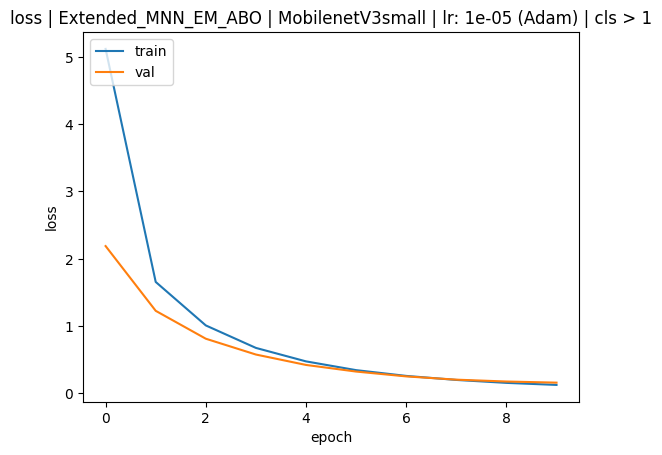

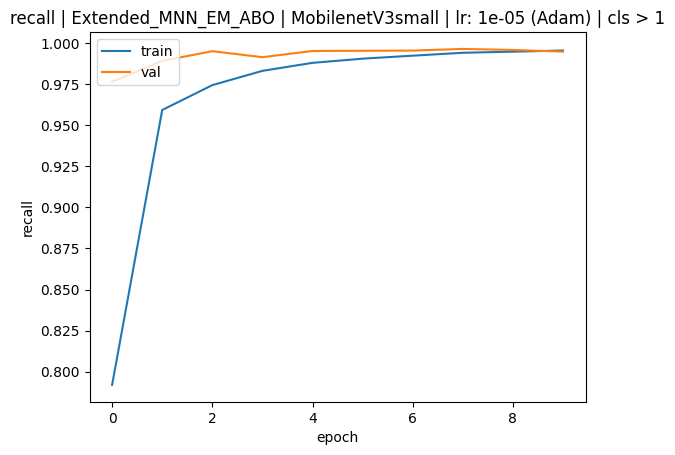

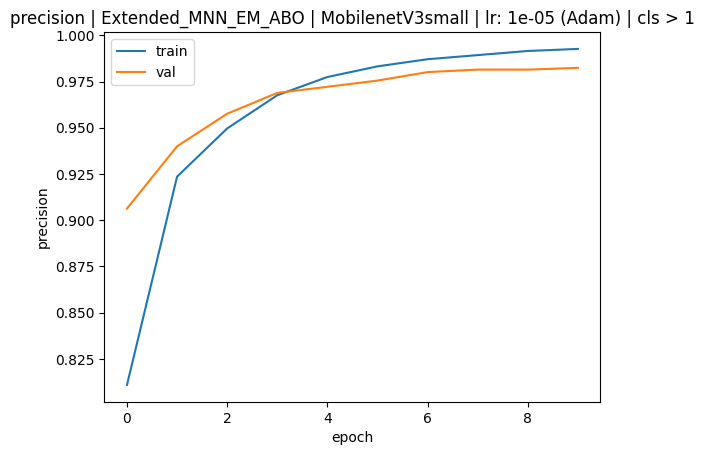

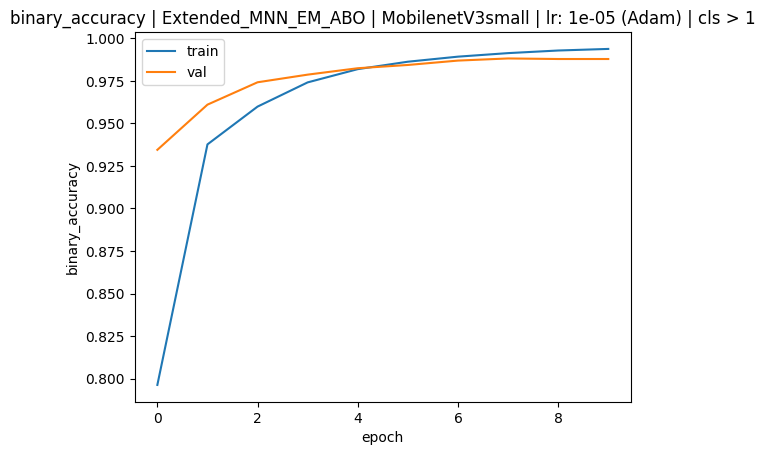

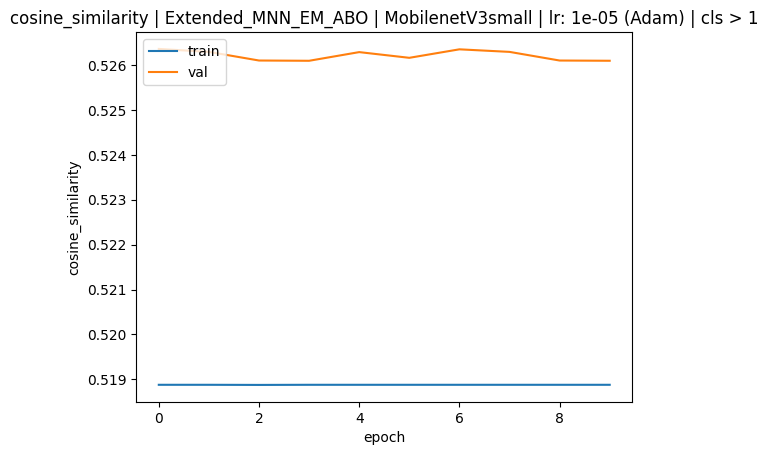

In [47]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [48]:
from utils.metrics import evaluate

In [49]:
evaluate(ext_mnn_em.model, [img_test, text_test, text2_test], labels_test,
         log_dir, model_name, img_model.name, optimizer_name, learning_rate,
         config["data"]["cls"])

16817/16817 [==============================] - 101s 6ms/step - loss: 0.1584 - recall: 0.9964 - precision: 0.9824 - binary_accuracy: 0.9889 - cosine_similarity: 0.5183
